# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

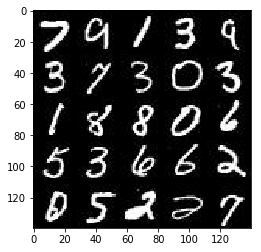

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

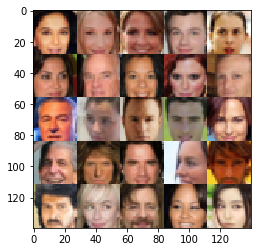

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(tf.float32,
                                 shape=(None, image_width, image_height, image_channels),
                                 name='real_inputs')
    z_input = tf.placeholder(tf.float32,
                             shape=(None, z_dim),
                             name='z_input')
    learning_rate = tf.placeholder(tf.float32,
                                   shape=None,
                                   name='learning_rate')

    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(x0, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2 
    with tf.variable_scope('discriminator', reuse=reuse):
        #input layer 28x28x3
        x1 = tf.layers.conv2d(x0, 64, 5, strides=2, padding='same') #fc
        relu1 = tf.maximum(alpha*x1, x1)
        
        # 14x14x32
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same') #fc
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same') #fc
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.5)
        
        # 4x4x256 --> flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 4*4*512)     #first fc 
        x1 = tf.reshape(x1, (-1, 4, 4, 512)) #reshape to input of Conv layer
        x1 = tf.layers.batch_normalization(x1, training=is_train) 
        x1 = tf.maximum(alpha*x1, x1)
        print (x1.shape)
        
        #second layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        print(x2.shape)
        
        #third layer
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        print(x3.shape)

        
        #fourth layer 
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        print(x4.shape)
        
        #output 32x32x3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real  = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    smooth_factor = 0.1 # prevent discriminator from being "too efficient"
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                labels=tf.ones_like(disc_model_real) * (1 - smooth_factor)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                labels=tf.zeros_like(disc_model_fake)))

    disc_loss = disc_loss_real + disc_loss_fake

    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                labels=tf.ones_like(disc_model_fake)))


    
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    iteration = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                iteration += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if iteration % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    losses.append((train_loss_d, train_loss_g))
                    
                    print("Epoch {}/{}, iteration {}:".format(epoch_i + 1, epochs, iteration),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if iteration % 100 == 0:
                     show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
    
        saver.save(sess, './checkpoints/generator.ckpt')
        
    
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)
Epoch 1/2, iteration 10: Discriminator Loss: 0.7999, Generator Loss: 1.6570
Epoch 1/2, iteration 20: Discriminator Loss: 0.4268, Generator Loss: 11.4514
Epoch 1/2, iteration 30: Discriminator Loss: 0.5923, Generator Loss: 8.2039
Epoch 1/2, iteration 40: Discriminator Loss: 0.9367, Generator Loss: 1.6877
Epoch 1/2, iteration 50: Discriminator Loss: 0.5809, Generator Loss: 2.1526
Epoch 1/2, iteration 60: Discriminator Loss: 0.7892, Generator Loss: 2.0374
Epoch 1/2, iteration 70: Discriminator Loss: 0.4853, Generator Loss: 14.0828
Epoch 1/2, iteration 80: Discriminator Loss: 0.4902, Generator Loss: 3.1680
Epoch 1/2, iteration 90: Discriminator Loss: 2.0579, Generator Loss: 0.2589
Epoch 1/2, iteration 100: Discriminator Loss: 0.5764, Generator Loss: 2.5821
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


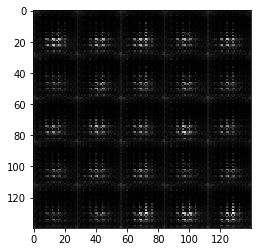

Epoch 1/2, iteration 110: Discriminator Loss: 0.6548, Generator Loss: 2.0140
Epoch 1/2, iteration 120: Discriminator Loss: 0.8498, Generator Loss: 2.6960
Epoch 1/2, iteration 130: Discriminator Loss: 0.7577, Generator Loss: 1.9200
Epoch 1/2, iteration 140: Discriminator Loss: 0.4468, Generator Loss: 3.9419
Epoch 1/2, iteration 150: Discriminator Loss: 0.5870, Generator Loss: 2.5375
Epoch 1/2, iteration 160: Discriminator Loss: 0.8534, Generator Loss: 2.0787
Epoch 1/2, iteration 170: Discriminator Loss: 0.9874, Generator Loss: 1.2891
Epoch 1/2, iteration 180: Discriminator Loss: 0.8967, Generator Loss: 1.8929
Epoch 1/2, iteration 190: Discriminator Loss: 0.8942, Generator Loss: 1.7345
Epoch 1/2, iteration 200: Discriminator Loss: 0.6266, Generator Loss: 2.2208
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


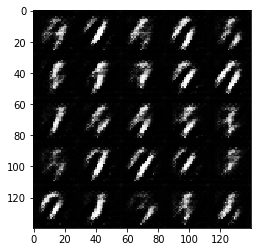

Epoch 1/2, iteration 210: Discriminator Loss: 0.8256, Generator Loss: 3.2766
Epoch 1/2, iteration 220: Discriminator Loss: 0.8413, Generator Loss: 2.5640
Epoch 1/2, iteration 230: Discriminator Loss: 1.1368, Generator Loss: 1.2484
Epoch 1/2, iteration 240: Discriminator Loss: 0.9066, Generator Loss: 1.8588
Epoch 1/2, iteration 250: Discriminator Loss: 0.9983, Generator Loss: 1.5038
Epoch 1/2, iteration 260: Discriminator Loss: 1.4578, Generator Loss: 0.8425
Epoch 1/2, iteration 270: Discriminator Loss: 1.0277, Generator Loss: 1.3892
Epoch 1/2, iteration 280: Discriminator Loss: 1.0901, Generator Loss: 1.2836
Epoch 1/2, iteration 290: Discriminator Loss: 0.9834, Generator Loss: 1.6498
Epoch 1/2, iteration 300: Discriminator Loss: 1.3057, Generator Loss: 0.9416
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


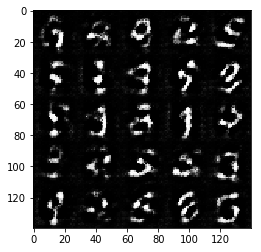

Epoch 1/2, iteration 310: Discriminator Loss: 0.9886, Generator Loss: 2.4008
Epoch 1/2, iteration 320: Discriminator Loss: 1.2274, Generator Loss: 0.8358
Epoch 1/2, iteration 330: Discriminator Loss: 1.0815, Generator Loss: 1.4427
Epoch 1/2, iteration 340: Discriminator Loss: 1.0485, Generator Loss: 1.3423
Epoch 1/2, iteration 350: Discriminator Loss: 0.9157, Generator Loss: 2.4006
Epoch 1/2, iteration 360: Discriminator Loss: 1.2477, Generator Loss: 0.9002
Epoch 1/2, iteration 370: Discriminator Loss: 1.0152, Generator Loss: 1.5058
Epoch 1/2, iteration 380: Discriminator Loss: 1.2084, Generator Loss: 1.4206
Epoch 1/2, iteration 390: Discriminator Loss: 1.2151, Generator Loss: 1.1429
Epoch 1/2, iteration 400: Discriminator Loss: 1.3541, Generator Loss: 0.8509
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


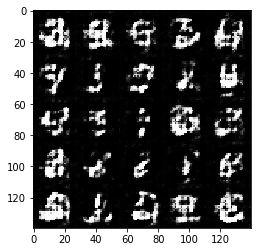

Epoch 1/2, iteration 410: Discriminator Loss: 0.9511, Generator Loss: 1.2850
Epoch 1/2, iteration 420: Discriminator Loss: 1.1186, Generator Loss: 1.1000
Epoch 1/2, iteration 430: Discriminator Loss: 1.2876, Generator Loss: 1.9056
Epoch 1/2, iteration 440: Discriminator Loss: 0.8793, Generator Loss: 1.6192
Epoch 1/2, iteration 450: Discriminator Loss: 1.0109, Generator Loss: 1.2111
Epoch 1/2, iteration 460: Discriminator Loss: 1.0993, Generator Loss: 1.8717
Epoch 1/2, iteration 470: Discriminator Loss: 1.1394, Generator Loss: 1.4624
Epoch 1/2, iteration 480: Discriminator Loss: 1.2176, Generator Loss: 1.0449
Epoch 1/2, iteration 490: Discriminator Loss: 1.1771, Generator Loss: 1.7006
Epoch 1/2, iteration 500: Discriminator Loss: 1.0045, Generator Loss: 1.2438
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


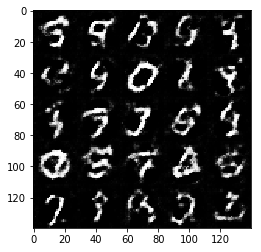

Epoch 1/2, iteration 510: Discriminator Loss: 1.1322, Generator Loss: 1.1391
Epoch 1/2, iteration 520: Discriminator Loss: 1.1771, Generator Loss: 0.9646
Epoch 1/2, iteration 530: Discriminator Loss: 1.3970, Generator Loss: 0.6421
Epoch 1/2, iteration 540: Discriminator Loss: 1.1153, Generator Loss: 1.6500
Epoch 1/2, iteration 550: Discriminator Loss: 1.4874, Generator Loss: 0.6093
Epoch 1/2, iteration 560: Discriminator Loss: 1.2558, Generator Loss: 0.8848
Epoch 1/2, iteration 570: Discriminator Loss: 1.2323, Generator Loss: 1.2266
Epoch 1/2, iteration 580: Discriminator Loss: 1.0290, Generator Loss: 1.3969
Epoch 1/2, iteration 590: Discriminator Loss: 1.1644, Generator Loss: 1.3809
Epoch 1/2, iteration 600: Discriminator Loss: 1.0751, Generator Loss: 0.9405
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


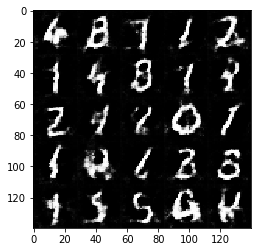

Epoch 1/2, iteration 610: Discriminator Loss: 1.2069, Generator Loss: 1.0252
Epoch 1/2, iteration 620: Discriminator Loss: 1.0733, Generator Loss: 1.0858
Epoch 1/2, iteration 630: Discriminator Loss: 1.1559, Generator Loss: 1.1329
Epoch 1/2, iteration 640: Discriminator Loss: 1.1661, Generator Loss: 0.9186
Epoch 1/2, iteration 650: Discriminator Loss: 1.2265, Generator Loss: 0.7587
Epoch 1/2, iteration 660: Discriminator Loss: 1.1295, Generator Loss: 1.3636
Epoch 1/2, iteration 670: Discriminator Loss: 1.1802, Generator Loss: 1.1172
Epoch 1/2, iteration 680: Discriminator Loss: 1.0735, Generator Loss: 1.3145
Epoch 1/2, iteration 690: Discriminator Loss: 1.1550, Generator Loss: 1.1693
Epoch 1/2, iteration 700: Discriminator Loss: 1.3477, Generator Loss: 1.1417
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


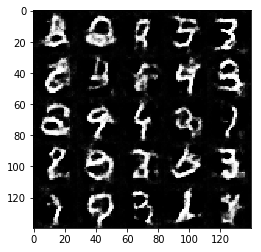

Epoch 1/2, iteration 710: Discriminator Loss: 1.5189, Generator Loss: 0.5709
Epoch 1/2, iteration 720: Discriminator Loss: 1.1515, Generator Loss: 1.0405
Epoch 1/2, iteration 730: Discriminator Loss: 1.0430, Generator Loss: 1.0859
Epoch 1/2, iteration 740: Discriminator Loss: 1.1122, Generator Loss: 1.1119
Epoch 1/2, iteration 750: Discriminator Loss: 1.0195, Generator Loss: 1.3886
Epoch 1/2, iteration 760: Discriminator Loss: 1.1096, Generator Loss: 1.3711
Epoch 1/2, iteration 770: Discriminator Loss: 1.2294, Generator Loss: 1.1131
Epoch 1/2, iteration 780: Discriminator Loss: 1.2399, Generator Loss: 1.7993
Epoch 1/2, iteration 790: Discriminator Loss: 1.2107, Generator Loss: 0.9508
Epoch 1/2, iteration 800: Discriminator Loss: 1.2380, Generator Loss: 1.3221
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


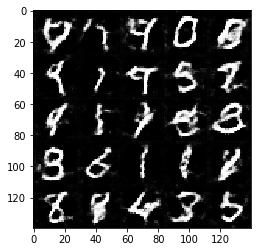

Epoch 1/2, iteration 810: Discriminator Loss: 1.1010, Generator Loss: 1.3029
Epoch 1/2, iteration 820: Discriminator Loss: 1.1089, Generator Loss: 1.2232
Epoch 1/2, iteration 830: Discriminator Loss: 1.2050, Generator Loss: 0.9604
Epoch 1/2, iteration 840: Discriminator Loss: 1.2988, Generator Loss: 1.4266
Epoch 1/2, iteration 850: Discriminator Loss: 1.0558, Generator Loss: 1.3459
Epoch 1/2, iteration 860: Discriminator Loss: 1.1463, Generator Loss: 1.5097
Epoch 1/2, iteration 870: Discriminator Loss: 1.0774, Generator Loss: 1.3981
Epoch 1/2, iteration 880: Discriminator Loss: 1.2228, Generator Loss: 1.2128
Epoch 1/2, iteration 890: Discriminator Loss: 1.1836, Generator Loss: 0.7859
Epoch 1/2, iteration 900: Discriminator Loss: 1.3408, Generator Loss: 0.6631
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


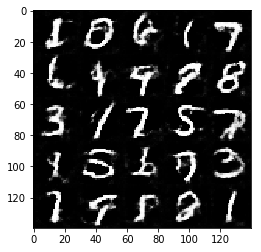

Epoch 1/2, iteration 910: Discriminator Loss: 1.2754, Generator Loss: 1.5879
Epoch 1/2, iteration 920: Discriminator Loss: 1.1206, Generator Loss: 1.0430
Epoch 1/2, iteration 930: Discriminator Loss: 1.1046, Generator Loss: 1.6250
Epoch 2/2, iteration 940: Discriminator Loss: 1.2145, Generator Loss: 1.4356
Epoch 2/2, iteration 950: Discriminator Loss: 1.0983, Generator Loss: 0.9261
Epoch 2/2, iteration 960: Discriminator Loss: 1.3440, Generator Loss: 2.4751
Epoch 2/2, iteration 970: Discriminator Loss: 1.0470, Generator Loss: 1.0802
Epoch 2/2, iteration 980: Discriminator Loss: 1.0473, Generator Loss: 1.4548
Epoch 2/2, iteration 990: Discriminator Loss: 1.2985, Generator Loss: 1.0851
Epoch 2/2, iteration 1000: Discriminator Loss: 1.3120, Generator Loss: 0.6765
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


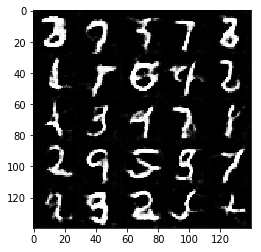

Epoch 2/2, iteration 1010: Discriminator Loss: 1.3139, Generator Loss: 0.7410
Epoch 2/2, iteration 1020: Discriminator Loss: 1.4986, Generator Loss: 0.5226
Epoch 2/2, iteration 1030: Discriminator Loss: 1.1275, Generator Loss: 0.9652
Epoch 2/2, iteration 1040: Discriminator Loss: 1.2127, Generator Loss: 1.8008
Epoch 2/2, iteration 1050: Discriminator Loss: 1.5882, Generator Loss: 0.5763
Epoch 2/2, iteration 1060: Discriminator Loss: 1.1607, Generator Loss: 0.9423
Epoch 2/2, iteration 1070: Discriminator Loss: 1.1246, Generator Loss: 0.8851
Epoch 2/2, iteration 1080: Discriminator Loss: 1.1008, Generator Loss: 1.2788
Epoch 2/2, iteration 1090: Discriminator Loss: 1.2364, Generator Loss: 0.9020
Epoch 2/2, iteration 1100: Discriminator Loss: 1.0121, Generator Loss: 1.2502
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


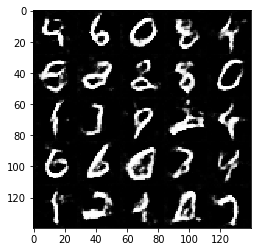

Epoch 2/2, iteration 1110: Discriminator Loss: 1.2426, Generator Loss: 0.7310
Epoch 2/2, iteration 1120: Discriminator Loss: 0.9965, Generator Loss: 1.2167
Epoch 2/2, iteration 1130: Discriminator Loss: 1.7346, Generator Loss: 0.3779
Epoch 2/2, iteration 1140: Discriminator Loss: 1.1944, Generator Loss: 1.1001
Epoch 2/2, iteration 1150: Discriminator Loss: 1.1476, Generator Loss: 1.2954
Epoch 2/2, iteration 1160: Discriminator Loss: 1.0763, Generator Loss: 1.3605
Epoch 2/2, iteration 1170: Discriminator Loss: 1.1231, Generator Loss: 0.9534
Epoch 2/2, iteration 1180: Discriminator Loss: 1.0688, Generator Loss: 1.0894
Epoch 2/2, iteration 1190: Discriminator Loss: 1.3377, Generator Loss: 0.6893
Epoch 2/2, iteration 1200: Discriminator Loss: 1.0556, Generator Loss: 1.4375
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


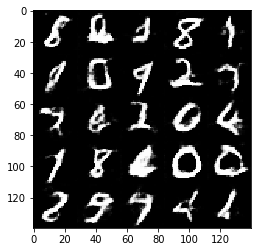

Epoch 2/2, iteration 1210: Discriminator Loss: 1.0571, Generator Loss: 1.9723
Epoch 2/2, iteration 1220: Discriminator Loss: 1.0581, Generator Loss: 1.1194
Epoch 2/2, iteration 1230: Discriminator Loss: 1.1543, Generator Loss: 0.8469
Epoch 2/2, iteration 1240: Discriminator Loss: 1.0269, Generator Loss: 1.0883
Epoch 2/2, iteration 1250: Discriminator Loss: 4.0768, Generator Loss: 4.9182
Epoch 2/2, iteration 1260: Discriminator Loss: 0.9220, Generator Loss: 1.5152
Epoch 2/2, iteration 1270: Discriminator Loss: 1.2187, Generator Loss: 1.0038
Epoch 2/2, iteration 1280: Discriminator Loss: 1.0316, Generator Loss: 1.4154
Epoch 2/2, iteration 1290: Discriminator Loss: 1.0036, Generator Loss: 1.3139
Epoch 2/2, iteration 1300: Discriminator Loss: 1.0604, Generator Loss: 1.2342
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


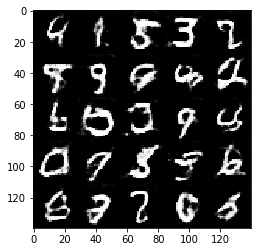

Epoch 2/2, iteration 1310: Discriminator Loss: 1.3608, Generator Loss: 0.7792
Epoch 2/2, iteration 1320: Discriminator Loss: 1.0175, Generator Loss: 1.0775
Epoch 2/2, iteration 1330: Discriminator Loss: 0.9990, Generator Loss: 1.3243
Epoch 2/2, iteration 1340: Discriminator Loss: 1.6070, Generator Loss: 2.2731
Epoch 2/2, iteration 1350: Discriminator Loss: 0.9324, Generator Loss: 1.4505
Epoch 2/2, iteration 1360: Discriminator Loss: 1.2022, Generator Loss: 0.9508
Epoch 2/2, iteration 1370: Discriminator Loss: 2.4170, Generator Loss: 3.7206
Epoch 2/2, iteration 1380: Discriminator Loss: 1.1607, Generator Loss: 1.0808
Epoch 2/2, iteration 1390: Discriminator Loss: 1.0944, Generator Loss: 1.2871
Epoch 2/2, iteration 1400: Discriminator Loss: 1.2837, Generator Loss: 0.7606
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


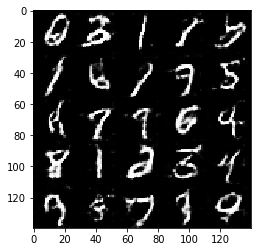

Epoch 2/2, iteration 1410: Discriminator Loss: 0.8395, Generator Loss: 1.5312
Epoch 2/2, iteration 1420: Discriminator Loss: 1.4885, Generator Loss: 2.3394
Epoch 2/2, iteration 1430: Discriminator Loss: 1.2537, Generator Loss: 0.9830
Epoch 2/2, iteration 1440: Discriminator Loss: 1.0178, Generator Loss: 1.1391
Epoch 2/2, iteration 1450: Discriminator Loss: 1.0449, Generator Loss: 1.5601
Epoch 2/2, iteration 1460: Discriminator Loss: 1.0105, Generator Loss: 1.4833
Epoch 2/2, iteration 1470: Discriminator Loss: 1.2542, Generator Loss: 0.6315
Epoch 2/2, iteration 1480: Discriminator Loss: 1.1341, Generator Loss: 1.0636
Epoch 2/2, iteration 1490: Discriminator Loss: 1.1407, Generator Loss: 0.9763
Epoch 2/2, iteration 1500: Discriminator Loss: 1.3694, Generator Loss: 0.6712
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


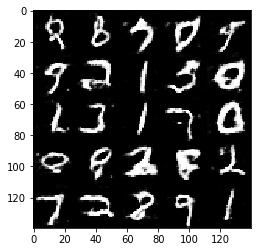

Epoch 2/2, iteration 1510: Discriminator Loss: 1.2886, Generator Loss: 0.8109
Epoch 2/2, iteration 1520: Discriminator Loss: 1.0388, Generator Loss: 0.9562
Epoch 2/2, iteration 1530: Discriminator Loss: 1.1750, Generator Loss: 0.9584
Epoch 2/2, iteration 1540: Discriminator Loss: 1.2136, Generator Loss: 0.9377
Epoch 2/2, iteration 1550: Discriminator Loss: 0.9325, Generator Loss: 1.3124
Epoch 2/2, iteration 1560: Discriminator Loss: 1.2206, Generator Loss: 0.9220
Epoch 2/2, iteration 1570: Discriminator Loss: 1.2125, Generator Loss: 0.8851
Epoch 2/2, iteration 1580: Discriminator Loss: 1.0213, Generator Loss: 1.0515
Epoch 2/2, iteration 1590: Discriminator Loss: 2.2926, Generator Loss: 0.2458
Epoch 2/2, iteration 1600: Discriminator Loss: 1.0948, Generator Loss: 1.5086
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


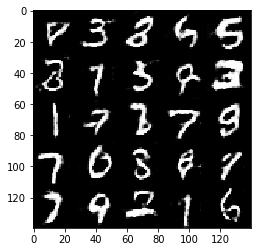

Epoch 2/2, iteration 1610: Discriminator Loss: 1.0981, Generator Loss: 1.3330
Epoch 2/2, iteration 1620: Discriminator Loss: 1.2450, Generator Loss: 0.7948
Epoch 2/2, iteration 1630: Discriminator Loss: 0.9815, Generator Loss: 1.4771
Epoch 2/2, iteration 1640: Discriminator Loss: 1.0122, Generator Loss: 1.3680
Epoch 2/2, iteration 1650: Discriminator Loss: 1.1529, Generator Loss: 0.8879
Epoch 2/2, iteration 1660: Discriminator Loss: 0.9585, Generator Loss: 1.4773
Epoch 2/2, iteration 1670: Discriminator Loss: 1.1719, Generator Loss: 0.9017
Epoch 2/2, iteration 1680: Discriminator Loss: 1.1117, Generator Loss: 1.0711
Epoch 2/2, iteration 1690: Discriminator Loss: 1.3591, Generator Loss: 0.6133
Epoch 2/2, iteration 1700: Discriminator Loss: 1.1228, Generator Loss: 1.4908
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


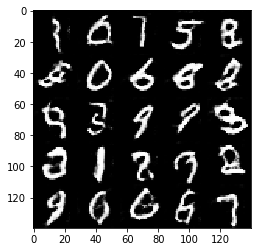

Epoch 2/2, iteration 1710: Discriminator Loss: 1.0964, Generator Loss: 1.2773
Epoch 2/2, iteration 1720: Discriminator Loss: 0.9115, Generator Loss: 1.8006
Epoch 2/2, iteration 1730: Discriminator Loss: 0.9795, Generator Loss: 1.5743
Epoch 2/2, iteration 1740: Discriminator Loss: 1.1537, Generator Loss: 0.8463
Epoch 2/2, iteration 1750: Discriminator Loss: 1.2652, Generator Loss: 0.8994
Epoch 2/2, iteration 1760: Discriminator Loss: 0.9964, Generator Loss: 1.1868
Epoch 2/2, iteration 1770: Discriminator Loss: 1.2521, Generator Loss: 0.9987
Epoch 2/2, iteration 1780: Discriminator Loss: 1.3198, Generator Loss: 1.8063
Epoch 2/2, iteration 1790: Discriminator Loss: 1.0523, Generator Loss: 1.1890
Epoch 2/2, iteration 1800: Discriminator Loss: 1.2445, Generator Loss: 0.8752
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


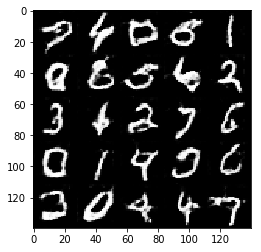

Epoch 2/2, iteration 1810: Discriminator Loss: 1.2988, Generator Loss: 1.9578
Epoch 2/2, iteration 1820: Discriminator Loss: 1.1868, Generator Loss: 1.1882
Epoch 2/2, iteration 1830: Discriminator Loss: 1.0561, Generator Loss: 1.2912
Epoch 2/2, iteration 1840: Discriminator Loss: 1.1851, Generator Loss: 0.8133
Epoch 2/2, iteration 1850: Discriminator Loss: 1.2597, Generator Loss: 0.7246
Epoch 2/2, iteration 1860: Discriminator Loss: 1.2088, Generator Loss: 0.6426
Epoch 2/2, iteration 1870: Discriminator Loss: 1.1325, Generator Loss: 0.9000


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.50

!mkdir checkpoints

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)
Epoch 1/1, iteration 10: Discriminator Loss: 2.5656, Generator Loss: 3.3331
Epoch 1/1, iteration 20: Discriminator Loss: 0.8019, Generator Loss: 2.6092
Epoch 1/1, iteration 30: Discriminator Loss: 0.8711, Generator Loss: 2.6929
Epoch 1/1, iteration 40: Discriminator Loss: 1.8628, Generator Loss: 6.1141
Epoch 1/1, iteration 50: Discriminator Loss: 2.5143, Generator Loss: 1.0959
Epoch 1/1, iteration 60: Discriminator Loss: 0.6081, Generator Loss: 3.4446
Epoch 1/1, iteration 70: Discriminator Loss: 2.5869, Generator Loss: 0.9048
Epoch 1/1, iteration 80: Discriminator Loss: 9.5670, Generator Loss: 14.4852
Epoch 1/1, iteration 90: Discriminator Loss: 1.0582, Generator Loss: 1.7755
Epoch 1/1, iteration 100: Discriminator Loss: 1.3870, Generator Loss: 3.2163
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


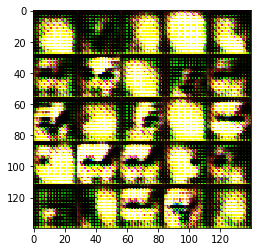

Epoch 1/1, iteration 110: Discriminator Loss: 1.1013, Generator Loss: 1.5632
Epoch 1/1, iteration 120: Discriminator Loss: 0.6447, Generator Loss: 2.3268
Epoch 1/1, iteration 130: Discriminator Loss: 0.8083, Generator Loss: 2.4583
Epoch 1/1, iteration 140: Discriminator Loss: 0.8251, Generator Loss: 1.6492
Epoch 1/1, iteration 150: Discriminator Loss: 0.6976, Generator Loss: 1.9067
Epoch 1/1, iteration 160: Discriminator Loss: 0.7492, Generator Loss: 1.9156
Epoch 1/1, iteration 170: Discriminator Loss: 0.9506, Generator Loss: 1.0640
Epoch 1/1, iteration 180: Discriminator Loss: 0.9850, Generator Loss: 1.6933
Epoch 1/1, iteration 190: Discriminator Loss: 4.6895, Generator Loss: 8.5854
Epoch 1/1, iteration 200: Discriminator Loss: 1.6009, Generator Loss: 3.1220
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


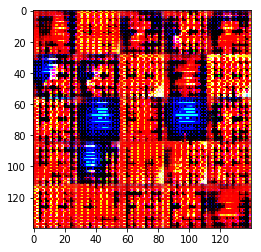

Epoch 1/1, iteration 210: Discriminator Loss: 0.7775, Generator Loss: 2.6818
Epoch 1/1, iteration 220: Discriminator Loss: 0.9268, Generator Loss: 1.4753
Epoch 1/1, iteration 230: Discriminator Loss: 0.8694, Generator Loss: 1.3104
Epoch 1/1, iteration 240: Discriminator Loss: 6.7334, Generator Loss: 12.1983
Epoch 1/1, iteration 250: Discriminator Loss: 0.7865, Generator Loss: 1.3170
Epoch 1/1, iteration 260: Discriminator Loss: 0.4400, Generator Loss: 3.0506
Epoch 1/1, iteration 270: Discriminator Loss: 0.4064, Generator Loss: 3.7648
Epoch 1/1, iteration 280: Discriminator Loss: 0.4302, Generator Loss: 3.1874
Epoch 1/1, iteration 290: Discriminator Loss: 0.4368, Generator Loss: 4.1189
Epoch 1/1, iteration 300: Discriminator Loss: 0.3815, Generator Loss: 5.6341
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


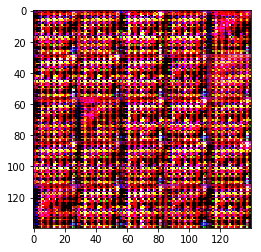

Epoch 1/1, iteration 310: Discriminator Loss: 0.3715, Generator Loss: 4.6037
Epoch 1/1, iteration 320: Discriminator Loss: 0.4057, Generator Loss: 3.5831
Epoch 1/1, iteration 330: Discriminator Loss: 2.0051, Generator Loss: 0.4178
Epoch 1/1, iteration 340: Discriminator Loss: 1.1952, Generator Loss: 1.9188
Epoch 1/1, iteration 350: Discriminator Loss: 1.2146, Generator Loss: 1.4672
Epoch 1/1, iteration 360: Discriminator Loss: 0.4777, Generator Loss: 3.4205
Epoch 1/1, iteration 370: Discriminator Loss: 0.8540, Generator Loss: 1.3078
Epoch 1/1, iteration 380: Discriminator Loss: 1.1337, Generator Loss: 0.9886
Epoch 1/1, iteration 390: Discriminator Loss: 0.8830, Generator Loss: 1.3093
Epoch 1/1, iteration 400: Discriminator Loss: 1.0587, Generator Loss: 1.7517
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


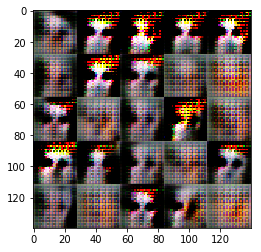

Epoch 1/1, iteration 410: Discriminator Loss: 0.5402, Generator Loss: 2.5633
Epoch 1/1, iteration 420: Discriminator Loss: 0.7847, Generator Loss: 1.5509
Epoch 1/1, iteration 430: Discriminator Loss: 0.6469, Generator Loss: 1.7938
Epoch 1/1, iteration 440: Discriminator Loss: 2.8841, Generator Loss: 3.3352
Epoch 1/1, iteration 450: Discriminator Loss: 0.9743, Generator Loss: 1.4624
Epoch 1/1, iteration 460: Discriminator Loss: 1.3909, Generator Loss: 0.7803
Epoch 1/1, iteration 470: Discriminator Loss: 0.8662, Generator Loss: 2.4178
Epoch 1/1, iteration 480: Discriminator Loss: 0.7807, Generator Loss: 1.5233
Epoch 1/1, iteration 490: Discriminator Loss: 0.8568, Generator Loss: 1.2091
Epoch 1/1, iteration 500: Discriminator Loss: 1.7461, Generator Loss: 0.8206
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


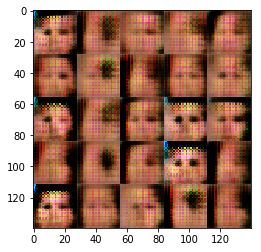

Epoch 1/1, iteration 510: Discriminator Loss: 1.0649, Generator Loss: 1.3699
Epoch 1/1, iteration 520: Discriminator Loss: 1.0371, Generator Loss: 1.0715
Epoch 1/1, iteration 530: Discriminator Loss: 1.5377, Generator Loss: 2.9747
Epoch 1/1, iteration 540: Discriminator Loss: 1.3293, Generator Loss: 1.0161
Epoch 1/1, iteration 550: Discriminator Loss: 0.7190, Generator Loss: 1.6990
Epoch 1/1, iteration 560: Discriminator Loss: 1.2000, Generator Loss: 1.2542
Epoch 1/1, iteration 570: Discriminator Loss: 1.0567, Generator Loss: 1.2265
Epoch 1/1, iteration 580: Discriminator Loss: 1.2813, Generator Loss: 0.8267
Epoch 1/1, iteration 590: Discriminator Loss: 1.6177, Generator Loss: 2.8457
Epoch 1/1, iteration 600: Discriminator Loss: 1.1065, Generator Loss: 0.7880
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


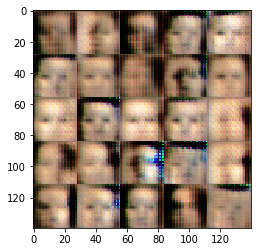

Epoch 1/1, iteration 610: Discriminator Loss: 1.3204, Generator Loss: 1.2638
Epoch 1/1, iteration 620: Discriminator Loss: 1.2824, Generator Loss: 0.7784
Epoch 1/1, iteration 630: Discriminator Loss: 1.1239, Generator Loss: 1.2395
Epoch 1/1, iteration 640: Discriminator Loss: 1.2617, Generator Loss: 0.8727
Epoch 1/1, iteration 650: Discriminator Loss: 1.0207, Generator Loss: 1.7408
Epoch 1/1, iteration 660: Discriminator Loss: 0.9961, Generator Loss: 1.4238
Epoch 1/1, iteration 670: Discriminator Loss: 1.0992, Generator Loss: 1.1327
Epoch 1/1, iteration 680: Discriminator Loss: 1.7477, Generator Loss: 3.7814
Epoch 1/1, iteration 690: Discriminator Loss: 0.9459, Generator Loss: 1.4168
Epoch 1/1, iteration 700: Discriminator Loss: 1.3997, Generator Loss: 0.8411
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


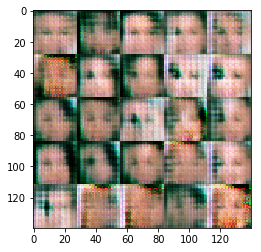

Epoch 1/1, iteration 710: Discriminator Loss: 1.0795, Generator Loss: 1.7457
Epoch 1/1, iteration 720: Discriminator Loss: 1.5044, Generator Loss: 0.9330
Epoch 1/1, iteration 730: Discriminator Loss: 1.1808, Generator Loss: 1.0337
Epoch 1/1, iteration 740: Discriminator Loss: 1.1159, Generator Loss: 1.6960
Epoch 1/1, iteration 750: Discriminator Loss: 1.2598, Generator Loss: 0.9893
Epoch 1/1, iteration 760: Discriminator Loss: 1.4206, Generator Loss: 1.2890
Epoch 1/1, iteration 770: Discriminator Loss: 1.1858, Generator Loss: 0.9793
Epoch 1/1, iteration 780: Discriminator Loss: 1.5004, Generator Loss: 2.2124
Epoch 1/1, iteration 790: Discriminator Loss: 1.0364, Generator Loss: 1.2489
Epoch 1/1, iteration 800: Discriminator Loss: 1.6796, Generator Loss: 0.4441
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


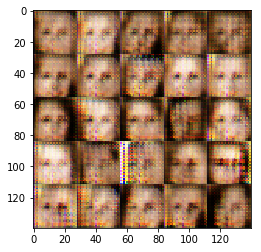

Epoch 1/1, iteration 810: Discriminator Loss: 0.9978, Generator Loss: 1.1819
Epoch 1/1, iteration 820: Discriminator Loss: 0.8986, Generator Loss: 1.6638
Epoch 1/1, iteration 830: Discriminator Loss: 1.2562, Generator Loss: 0.9387
Epoch 1/1, iteration 840: Discriminator Loss: 1.2400, Generator Loss: 0.9599
Epoch 1/1, iteration 850: Discriminator Loss: 1.2278, Generator Loss: 0.8856
Epoch 1/1, iteration 860: Discriminator Loss: 1.1162, Generator Loss: 1.1752
Epoch 1/1, iteration 870: Discriminator Loss: 1.5255, Generator Loss: 1.0075
Epoch 1/1, iteration 880: Discriminator Loss: 1.6718, Generator Loss: 2.3081
Epoch 1/1, iteration 890: Discriminator Loss: 1.1547, Generator Loss: 1.0103
Epoch 1/1, iteration 900: Discriminator Loss: 1.0863, Generator Loss: 1.0669
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


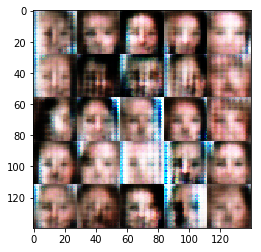

Epoch 1/1, iteration 910: Discriminator Loss: 1.7333, Generator Loss: 0.5331
Epoch 1/1, iteration 920: Discriminator Loss: 1.3741, Generator Loss: 0.6365
Epoch 1/1, iteration 930: Discriminator Loss: 1.5277, Generator Loss: 0.5567
Epoch 1/1, iteration 940: Discriminator Loss: 1.2684, Generator Loss: 1.4610
Epoch 1/1, iteration 950: Discriminator Loss: 1.4807, Generator Loss: 1.1033
Epoch 1/1, iteration 960: Discriminator Loss: 1.0186, Generator Loss: 1.2118
Epoch 1/1, iteration 970: Discriminator Loss: 1.3857, Generator Loss: 1.4182
Epoch 1/1, iteration 980: Discriminator Loss: 1.1156, Generator Loss: 1.3044
Epoch 1/1, iteration 990: Discriminator Loss: 1.1485, Generator Loss: 1.2238
Epoch 1/1, iteration 1000: Discriminator Loss: 1.2267, Generator Loss: 0.9917
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


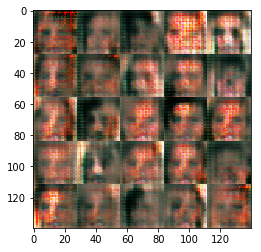

Epoch 1/1, iteration 1010: Discriminator Loss: 1.1356, Generator Loss: 1.0540
Epoch 1/1, iteration 1020: Discriminator Loss: 1.1856, Generator Loss: 0.9122
Epoch 1/1, iteration 1030: Discriminator Loss: 1.3756, Generator Loss: 0.8197
Epoch 1/1, iteration 1040: Discriminator Loss: 1.5841, Generator Loss: 0.5328
Epoch 1/1, iteration 1050: Discriminator Loss: 1.2308, Generator Loss: 1.4011
Epoch 1/1, iteration 1060: Discriminator Loss: 1.1149, Generator Loss: 0.9783
Epoch 1/1, iteration 1070: Discriminator Loss: 1.4096, Generator Loss: 0.9149
Epoch 1/1, iteration 1080: Discriminator Loss: 1.3202, Generator Loss: 0.7215
Epoch 1/1, iteration 1090: Discriminator Loss: 1.5831, Generator Loss: 0.4650
Epoch 1/1, iteration 1100: Discriminator Loss: 1.3936, Generator Loss: 0.8875
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


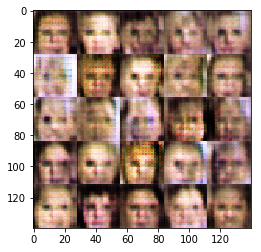

Epoch 1/1, iteration 1110: Discriminator Loss: 0.8775, Generator Loss: 1.8193
Epoch 1/1, iteration 1120: Discriminator Loss: 1.3715, Generator Loss: 0.6328
Epoch 1/1, iteration 1130: Discriminator Loss: 1.1788, Generator Loss: 0.9110
Epoch 1/1, iteration 1140: Discriminator Loss: 1.2019, Generator Loss: 1.2086
Epoch 1/1, iteration 1150: Discriminator Loss: 1.2755, Generator Loss: 0.8155
Epoch 1/1, iteration 1160: Discriminator Loss: 1.2545, Generator Loss: 1.4090
Epoch 1/1, iteration 1170: Discriminator Loss: 1.1731, Generator Loss: 0.8290
Epoch 1/1, iteration 1180: Discriminator Loss: 1.0029, Generator Loss: 1.4102
Epoch 1/1, iteration 1190: Discriminator Loss: 1.4360, Generator Loss: 0.6513
Epoch 1/1, iteration 1200: Discriminator Loss: 0.9739, Generator Loss: 1.2088
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


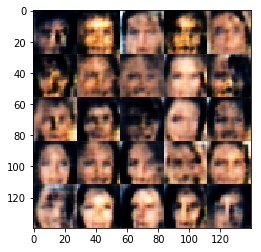

Epoch 1/1, iteration 1210: Discriminator Loss: 1.2240, Generator Loss: 0.8068
Epoch 1/1, iteration 1220: Discriminator Loss: 1.1662, Generator Loss: 0.9206
Epoch 1/1, iteration 1230: Discriminator Loss: 1.4194, Generator Loss: 0.5991
Epoch 1/1, iteration 1240: Discriminator Loss: 1.1337, Generator Loss: 0.8251
Epoch 1/1, iteration 1250: Discriminator Loss: 1.1587, Generator Loss: 1.1870
Epoch 1/1, iteration 1260: Discriminator Loss: 1.2000, Generator Loss: 0.9423
Epoch 1/1, iteration 1270: Discriminator Loss: 1.0563, Generator Loss: 1.7120
Epoch 1/1, iteration 1280: Discriminator Loss: 1.2478, Generator Loss: 1.3975
Epoch 1/1, iteration 1290: Discriminator Loss: 1.2555, Generator Loss: 1.8614
Epoch 1/1, iteration 1300: Discriminator Loss: 1.1976, Generator Loss: 0.7587
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


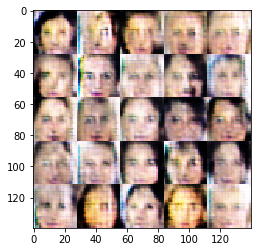

Epoch 1/1, iteration 1310: Discriminator Loss: 0.9629, Generator Loss: 1.4321
Epoch 1/1, iteration 1320: Discriminator Loss: 1.2239, Generator Loss: 1.2932
Epoch 1/1, iteration 1330: Discriminator Loss: 1.3321, Generator Loss: 2.1254
Epoch 1/1, iteration 1340: Discriminator Loss: 1.1755, Generator Loss: 1.0506
Epoch 1/1, iteration 1350: Discriminator Loss: 0.9459, Generator Loss: 1.6231
Epoch 1/1, iteration 1360: Discriminator Loss: 1.3334, Generator Loss: 0.8554
Epoch 1/1, iteration 1370: Discriminator Loss: 1.2496, Generator Loss: 0.8540
Epoch 1/1, iteration 1380: Discriminator Loss: 1.4560, Generator Loss: 0.9400
Epoch 1/1, iteration 1390: Discriminator Loss: 1.0564, Generator Loss: 0.9240
Epoch 1/1, iteration 1400: Discriminator Loss: 1.2592, Generator Loss: 0.9090
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


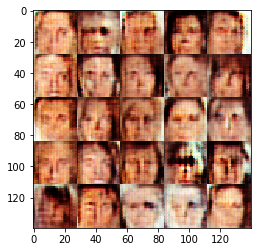

Epoch 1/1, iteration 1410: Discriminator Loss: 1.1532, Generator Loss: 1.0332
Epoch 1/1, iteration 1420: Discriminator Loss: 1.2381, Generator Loss: 1.1444
Epoch 1/1, iteration 1430: Discriminator Loss: 0.9484, Generator Loss: 1.0904
Epoch 1/1, iteration 1440: Discriminator Loss: 1.0125, Generator Loss: 1.2886
Epoch 1/1, iteration 1450: Discriminator Loss: 1.1453, Generator Loss: 1.5295
Epoch 1/1, iteration 1460: Discriminator Loss: 1.1088, Generator Loss: 1.0303
Epoch 1/1, iteration 1470: Discriminator Loss: 1.1665, Generator Loss: 0.9518
Epoch 1/1, iteration 1480: Discriminator Loss: 1.0643, Generator Loss: 1.5546
Epoch 1/1, iteration 1490: Discriminator Loss: 1.6483, Generator Loss: 0.5523
Epoch 1/1, iteration 1500: Discriminator Loss: 1.2976, Generator Loss: 0.7677
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


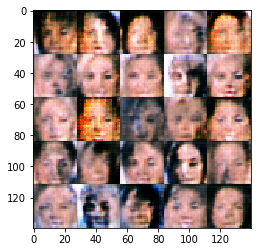

Epoch 1/1, iteration 1510: Discriminator Loss: 1.2638, Generator Loss: 1.4946
Epoch 1/1, iteration 1520: Discriminator Loss: 0.9854, Generator Loss: 1.4631
Epoch 1/1, iteration 1530: Discriminator Loss: 1.2178, Generator Loss: 1.1621
Epoch 1/1, iteration 1540: Discriminator Loss: 0.9978, Generator Loss: 1.6230
Epoch 1/1, iteration 1550: Discriminator Loss: 1.1765, Generator Loss: 1.0228
Epoch 1/1, iteration 1560: Discriminator Loss: 0.9791, Generator Loss: 1.6561
Epoch 1/1, iteration 1570: Discriminator Loss: 1.3030, Generator Loss: 1.1953
Epoch 1/1, iteration 1580: Discriminator Loss: 1.1136, Generator Loss: 1.1795
Epoch 1/1, iteration 1590: Discriminator Loss: 1.1856, Generator Loss: 1.0798
Epoch 1/1, iteration 1600: Discriminator Loss: 1.1167, Generator Loss: 1.4954
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


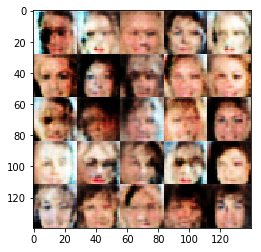

Epoch 1/1, iteration 1610: Discriminator Loss: 1.3854, Generator Loss: 0.7001
Epoch 1/1, iteration 1620: Discriminator Loss: 0.8998, Generator Loss: 1.3135
Epoch 1/1, iteration 1630: Discriminator Loss: 1.0837, Generator Loss: 1.0103
Epoch 1/1, iteration 1640: Discriminator Loss: 1.2772, Generator Loss: 0.8986
Epoch 1/1, iteration 1650: Discriminator Loss: 1.2505, Generator Loss: 1.1400
Epoch 1/1, iteration 1660: Discriminator Loss: 1.1818, Generator Loss: 1.1299
Epoch 1/1, iteration 1670: Discriminator Loss: 1.2768, Generator Loss: 0.7943
Epoch 1/1, iteration 1680: Discriminator Loss: 1.2097, Generator Loss: 1.3073
Epoch 1/1, iteration 1690: Discriminator Loss: 1.1522, Generator Loss: 1.5671
Epoch 1/1, iteration 1700: Discriminator Loss: 1.3409, Generator Loss: 1.0409
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


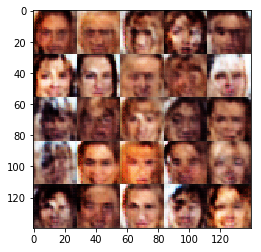

Epoch 1/1, iteration 1710: Discriminator Loss: 1.3228, Generator Loss: 1.0656
Epoch 1/1, iteration 1720: Discriminator Loss: 1.2810, Generator Loss: 0.7538
Epoch 1/1, iteration 1730: Discriminator Loss: 1.1319, Generator Loss: 1.5026
Epoch 1/1, iteration 1740: Discriminator Loss: 1.1820, Generator Loss: 1.2224
Epoch 1/1, iteration 1750: Discriminator Loss: 1.0346, Generator Loss: 1.2990
Epoch 1/1, iteration 1760: Discriminator Loss: 1.3295, Generator Loss: 1.0763
Epoch 1/1, iteration 1770: Discriminator Loss: 1.0582, Generator Loss: 1.1442
Epoch 1/1, iteration 1780: Discriminator Loss: 1.0900, Generator Loss: 1.0101
Epoch 1/1, iteration 1790: Discriminator Loss: 1.1888, Generator Loss: 0.8826
Epoch 1/1, iteration 1800: Discriminator Loss: 1.2907, Generator Loss: 2.0778
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


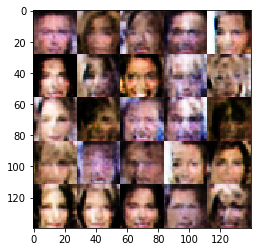

Epoch 1/1, iteration 1810: Discriminator Loss: 0.9748, Generator Loss: 1.2338
Epoch 1/1, iteration 1820: Discriminator Loss: 1.1706, Generator Loss: 1.3298
Epoch 1/1, iteration 1830: Discriminator Loss: 1.0612, Generator Loss: 1.1221
Epoch 1/1, iteration 1840: Discriminator Loss: 1.5403, Generator Loss: 0.7727
Epoch 1/1, iteration 1850: Discriminator Loss: 1.0355, Generator Loss: 1.6842
Epoch 1/1, iteration 1860: Discriminator Loss: 1.1958, Generator Loss: 0.8246
Epoch 1/1, iteration 1870: Discriminator Loss: 1.2389, Generator Loss: 0.8655
Epoch 1/1, iteration 1880: Discriminator Loss: 1.8157, Generator Loss: 0.4033
Epoch 1/1, iteration 1890: Discriminator Loss: 1.1116, Generator Loss: 1.0399
Epoch 1/1, iteration 1900: Discriminator Loss: 1.1533, Generator Loss: 1.1874
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


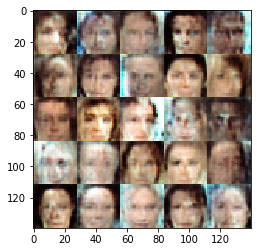

Epoch 1/1, iteration 1910: Discriminator Loss: 1.2027, Generator Loss: 1.0866
Epoch 1/1, iteration 1920: Discriminator Loss: 1.3563, Generator Loss: 1.0706
Epoch 1/1, iteration 1930: Discriminator Loss: 1.1154, Generator Loss: 1.0452
Epoch 1/1, iteration 1940: Discriminator Loss: 1.0981, Generator Loss: 1.2117
Epoch 1/1, iteration 1950: Discriminator Loss: 1.2574, Generator Loss: 1.0274
Epoch 1/1, iteration 1960: Discriminator Loss: 1.2942, Generator Loss: 0.9716
Epoch 1/1, iteration 1970: Discriminator Loss: 1.1770, Generator Loss: 0.8818
Epoch 1/1, iteration 1980: Discriminator Loss: 1.1885, Generator Loss: 0.9870
Epoch 1/1, iteration 1990: Discriminator Loss: 1.3213, Generator Loss: 1.4247
Epoch 1/1, iteration 2000: Discriminator Loss: 1.5349, Generator Loss: 0.6520
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


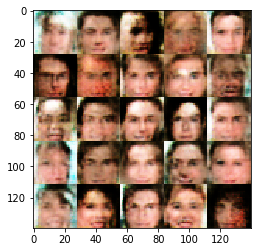

Epoch 1/1, iteration 2010: Discriminator Loss: 1.3261, Generator Loss: 1.1007
Epoch 1/1, iteration 2020: Discriminator Loss: 1.3525, Generator Loss: 0.8403
Epoch 1/1, iteration 2030: Discriminator Loss: 1.2897, Generator Loss: 1.4469
Epoch 1/1, iteration 2040: Discriminator Loss: 1.1120, Generator Loss: 1.0304
Epoch 1/1, iteration 2050: Discriminator Loss: 1.1734, Generator Loss: 1.1619
Epoch 1/1, iteration 2060: Discriminator Loss: 1.4643, Generator Loss: 0.8890
Epoch 1/1, iteration 2070: Discriminator Loss: 1.1633, Generator Loss: 0.7540
Epoch 1/1, iteration 2080: Discriminator Loss: 1.2106, Generator Loss: 1.0589
Epoch 1/1, iteration 2090: Discriminator Loss: 1.2430, Generator Loss: 1.1369
Epoch 1/1, iteration 2100: Discriminator Loss: 1.2891, Generator Loss: 1.1799
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


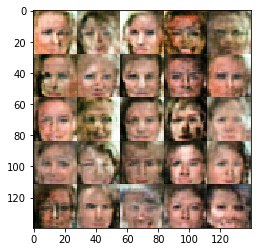

Epoch 1/1, iteration 2110: Discriminator Loss: 1.4190, Generator Loss: 0.6940
Epoch 1/1, iteration 2120: Discriminator Loss: 1.0393, Generator Loss: 1.2714
Epoch 1/1, iteration 2130: Discriminator Loss: 1.3340, Generator Loss: 0.8992
Epoch 1/1, iteration 2140: Discriminator Loss: 1.0449, Generator Loss: 1.0275
Epoch 1/1, iteration 2150: Discriminator Loss: 1.2891, Generator Loss: 1.6096
Epoch 1/1, iteration 2160: Discriminator Loss: 1.2422, Generator Loss: 0.9100
Epoch 1/1, iteration 2170: Discriminator Loss: 1.2993, Generator Loss: 1.0654
Epoch 1/1, iteration 2180: Discriminator Loss: 1.1785, Generator Loss: 1.2249
Epoch 1/1, iteration 2190: Discriminator Loss: 1.0979, Generator Loss: 1.1892
Epoch 1/1, iteration 2200: Discriminator Loss: 1.2641, Generator Loss: 0.7603
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


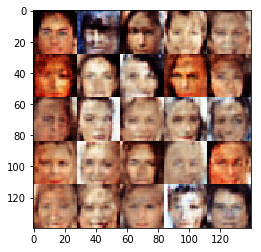

Epoch 1/1, iteration 2210: Discriminator Loss: 1.3357, Generator Loss: 0.8809
Epoch 1/1, iteration 2220: Discriminator Loss: 1.3175, Generator Loss: 0.9610
Epoch 1/1, iteration 2230: Discriminator Loss: 1.2236, Generator Loss: 0.8285
Epoch 1/1, iteration 2240: Discriminator Loss: 1.1587, Generator Loss: 1.0251
Epoch 1/1, iteration 2250: Discriminator Loss: 1.3827, Generator Loss: 0.9537
Epoch 1/1, iteration 2260: Discriminator Loss: 1.3621, Generator Loss: 0.6703
Epoch 1/1, iteration 2270: Discriminator Loss: 1.4488, Generator Loss: 0.9862
Epoch 1/1, iteration 2280: Discriminator Loss: 1.3918, Generator Loss: 0.6787
Epoch 1/1, iteration 2290: Discriminator Loss: 1.2086, Generator Loss: 1.2331
Epoch 1/1, iteration 2300: Discriminator Loss: 1.2005, Generator Loss: 0.9369
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


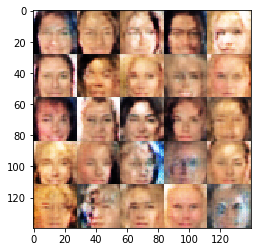

Epoch 1/1, iteration 2310: Discriminator Loss: 1.4666, Generator Loss: 0.5164
Epoch 1/1, iteration 2320: Discriminator Loss: 1.1888, Generator Loss: 0.7569
Epoch 1/1, iteration 2330: Discriminator Loss: 1.3255, Generator Loss: 0.8348
Epoch 1/1, iteration 2340: Discriminator Loss: 1.2706, Generator Loss: 1.3221
Epoch 1/1, iteration 2350: Discriminator Loss: 1.3534, Generator Loss: 1.2133
Epoch 1/1, iteration 2360: Discriminator Loss: 1.2651, Generator Loss: 1.1253
Epoch 1/1, iteration 2370: Discriminator Loss: 1.0519, Generator Loss: 1.0915
Epoch 1/1, iteration 2380: Discriminator Loss: 1.4314, Generator Loss: 0.6031
Epoch 1/1, iteration 2390: Discriminator Loss: 1.2594, Generator Loss: 1.1739
Epoch 1/1, iteration 2400: Discriminator Loss: 1.3050, Generator Loss: 0.7244
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


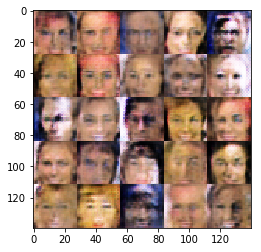

Epoch 1/1, iteration 2410: Discriminator Loss: 1.2710, Generator Loss: 0.9690
Epoch 1/1, iteration 2420: Discriminator Loss: 1.0837, Generator Loss: 0.7889
Epoch 1/1, iteration 2430: Discriminator Loss: 1.2511, Generator Loss: 1.0515
Epoch 1/1, iteration 2440: Discriminator Loss: 1.1529, Generator Loss: 1.0048
Epoch 1/1, iteration 2450: Discriminator Loss: 1.3374, Generator Loss: 1.0077
Epoch 1/1, iteration 2460: Discriminator Loss: 1.4033, Generator Loss: 1.1654
Epoch 1/1, iteration 2470: Discriminator Loss: 1.2547, Generator Loss: 0.9031
Epoch 1/1, iteration 2480: Discriminator Loss: 1.2184, Generator Loss: 1.1887
Epoch 1/1, iteration 2490: Discriminator Loss: 1.3679, Generator Loss: 0.7698
Epoch 1/1, iteration 2500: Discriminator Loss: 1.2227, Generator Loss: 0.8525
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


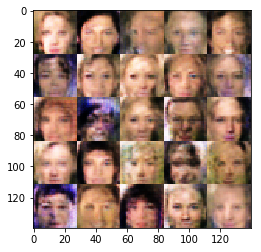

Epoch 1/1, iteration 2510: Discriminator Loss: 1.2895, Generator Loss: 0.9882
Epoch 1/1, iteration 2520: Discriminator Loss: 1.3853, Generator Loss: 0.8289
Epoch 1/1, iteration 2530: Discriminator Loss: 1.4237, Generator Loss: 1.0191
Epoch 1/1, iteration 2540: Discriminator Loss: 1.2454, Generator Loss: 0.6638
Epoch 1/1, iteration 2550: Discriminator Loss: 1.2863, Generator Loss: 0.9415
Epoch 1/1, iteration 2560: Discriminator Loss: 1.3615, Generator Loss: 1.4888
Epoch 1/1, iteration 2570: Discriminator Loss: 1.2541, Generator Loss: 0.8280
Epoch 1/1, iteration 2580: Discriminator Loss: 1.1601, Generator Loss: 1.0275
Epoch 1/1, iteration 2590: Discriminator Loss: 1.3268, Generator Loss: 0.8942
Epoch 1/1, iteration 2600: Discriminator Loss: 1.2106, Generator Loss: 0.9062
(?, 4, 4, 512)
(?, 7, 7, 128)
(?, 14, 14, 64)
(?, 28, 28, 32)


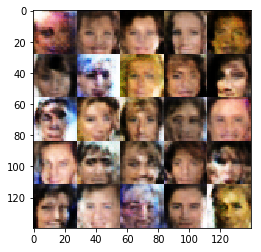

Epoch 1/1, iteration 2610: Discriminator Loss: 1.3720, Generator Loss: 0.6974
Epoch 1/1, iteration 2620: Discriminator Loss: 1.4031, Generator Loss: 0.7250


In [ ]:
#same as MNIST
batch_size = 64
z_dim = 128
learning_rate = 0.01
beta1 = 0.50


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.